In [2]:
## importing all libraries for our models

# pandas
import pandas as pd

# tensorflow
import tensorflow as tf
from tensorflow import keras

# tensorflow.keras
from keras import Input
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten 
from keras.layers import Conv2D, Conv1D, MaxPooling2D
from keras.layers import AveragePooling2D, AveragePooling1D
from keras.layers import GlobalMaxPooling1D, GlobalAveragePooling2D
from keras.layers import BatchNormalization, LSTM
from keras.layers import Concatenate, concatenate 
# Concatenate returns Concatenate object (layers), concatenate returns Tensor object (arrays)
from keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.utils import to_categorical
from keras import backend as K
from keras.constraints import max_norm, non_neg, unit_norm, min_max_norm
#from tensorflow.keras.utils import plot_model


# numpy
import numpy as np
from numpy import random

# sklearn
import sklearn

# sklearn for pipeline mixins
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.base import BaseEstimator, TransformerMixin

# sklearn for data splitting
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV

# sklearn for models
from sklearn.svm import SVC  
from sklearn.linear_model import LogisticRegression
from sklearn import neighbors
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.cluster import KMeans
from sklearn.model_selection import KFold
from sklearn.tree import export_graphviz
from sklearn.preprocessing import normalize

# sklearn for model evaluation
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score, roc_curve, auc, RocCurveDisplay
import sklearn.metrics.cluster as smc

# matplotlib.pyplot for plotting
from matplotlib import pyplot
import matplotlib.pyplot as plt 
import os

# misc
import itertools
from IPython.display import display
import matplotlib.pyplot as plt
import pydot
import graphviz
from PIL import Image
import numpy as np
from numpy import random
import glob
import rasterio as rio
import scipy.io as sio
import glob
import json

In [625]:
def get_max_wind(hurricane):
    name = hurricane + '/profile.json'
    f = open(name)
    profile = json.load(f)
    paths = profile['path']
    
    wind_speeds = []

    for path in paths:
        wind_speeds = np.append(wind_speeds, int(path['maxwind']))

    highest_wind = max(wind_speeds)
    
    return highest_wind

def get_imerg(imerg):
    # get imerg
    precips = glob.glob(imerg, recursive = True)
    precips.sort()
    imerg_array = np.load(precips[0])
    
    for file in precips[1:10]:
        load = np.load(file)
        print(file, load.shape)
        imerg_array = np.append(imerg_array, load, axis = 0)
    imerg_array = imerg_array.reshape(1, 10, 100, 100)
    
    return imerg_array

def get_sst(sst):
    # get sst
    temperatures = glob.glob(sst, recursive = True)
    temperatures.sort()
    sst_array = np.load(temperatures[0])
    
    for file in temperatures[1:4]:
        sst_array = np.append(sst_array, np.load(file), axis = 0)
    sst_array = sst_array.reshape(1, 4, 100, 100)
    
    return sst_array

def get_rgb(rgb):
    # get wavelet decomposed rgb
    colors = glob.glob(rgb, recursive = True)
    colors.sort()
    rgb_array = np.load(colors[0])
    
    for file in colors[1:4]:
        rgb_array = np.append(rgb_array, np.load(file), axis = 0)
    
    rgb_array = rgb_array[:, :100, :100]
    rgb_array = rgb_array.reshape(1, 48, 100, 100)
    
    return rgb_array

def lenCheck(imerg, sst, rgb):
    imergs = glob.glob(imerg)
    ssts = glob.glob(sst)
    rgbs = glob.glob(rgb)
    
    if len(imergs) < 10 or len(ssts) < 4 or len(rgbs) < 4:
        return False
    else:
        return True
    
def landCheck(folder, imerg, sst, rgb):
    name = folder + '/profile.json'
    f = open(name)
    profile = json.load(f)
    paths = profile['path']

    valid_dates = []
    for path in paths:
        valid_dates = np.append(valid_dates, str(path['date']))
        
    file = folder + '/noaa_sst_*.npy'

    sst = glob.glob(file, recursive = True)
    sst.sort()
    sst = sst[0:4]
    
    valid = True

    days = []

    for imerg in imergs:
        days = np.append(days, sst[-17:-9])

    for day in days:
        if day not in valid_dates:
            valid = False
        else:
            valid = True

    return valid
    
def createWindMap(profile):
    # return nparray(1, 100, 100)
    # hurricane center is  at (49,49),   each direction expand by 50 miles
    
    res = np.zeros((100, 100))
    
    maxwindradius = min(int(float(profile['maxwindradius'])/2), 49)
    maxwind = float(profile['maxwind'])
    
    keys = []
    for it in profile.keys():
        if 'kt' in it:
            keys.append(it)        
    keys.sort()
    
    for it in keys:
        if "ne" in it:
            radius = min(int(float(profile[it])/2), 49)
            for i in range(0, radius):
                for j in range(0, radius):
                    res[50-i-1,  50 +j] = max(0, float(it[:-4]))
        elif "se" in it:
            radius = min(int(float(profile[it])/2), 49)
            for i in range(0, radius):
                for j in range(0, radius):
                    res[50 + i,  50 +j] = max(0, float(it[:-4]))
        elif "nw" in it:
            radius = min(int(float(profile[it])/2), 49)
            for i in range(0, radius):
                for j in range(0, radius):
                    res[50-i-1,  50-j-1] = max(0, float(it[:-4]))
        elif "sw" in it:
            radius = min(int(float(profile[it])/2), 49)
            for i in range(0, radius):
                for j in range(0, radius):
                    res[50 + i,  50-j-1] = max(0, float(it[:-4]))
                        
    for i in range(-maxwindradius, maxwindradius):
        for j in range(-maxwindradius, maxwindradius):
            res[49 + i, 49 + j] = maxwind
    
    res = np.expand_dims(res, axis = 0)
                    
    return res
    

In [684]:
def getCategory(wind_speed): # based on the Saffir-Simpson Scale for hurricane classification
    
    thresholds = [('TD', 33), ('TS', 63), ('Category_1', 82), ('Category_2', 95), ('Category_3', 112), ('Category_4', 136)]
    
    for it in thresholds:
        if wind_speed <= it[1]:
            return it[0]
    return thresholds[-1][0]

def selectDay(cat_dictionary):
    pick_days = []
    for key in cat_dictionary.keys():
        index = len(cat_dictionary[key])-1
        day_list = cat_dictionary[key]
        day = day_list[index]
        pick_days = np.append(pick_days, day)
    return pick_days

def get100by100(three_d_tensor):
    new_tensor = three_d_tensor[:, :100, :100]
    return new_tensor    

def getStageByDay(folder, day):
    
    imerg_names = folder + '/imerg_precipitation_' + day + '_*.npy'
    sst_names = folder + '/noaa_sst_' + day + '*.npy'
    rgb_names = folder + '/wavelet_rgb_' + day + '*.npy'
    
    profile_name = folder + '/profile.json'
    f = open(profile_name)
    profile = json.load(f)
    paths = profile['path']

    imergs = glob.glob(imerg_names, recursive = True)
    ssts = glob.glob(sst_names, recursive = True)
    rgbs = glob.glob(rgb_names, recursive = True)
    
    imerg_array = np.zeros((100, 100))
    for imerg in imergs:
        imerg_array = imerg_array + np.load(imerg)

    imerg_array = imerg_array.reshape(1, 100, 100)
    imerg_array = imerg_array / len(imergs)
    
    if (not rgbs) or (not ssts):
        print("no rgbs or ssts: ", folder, day)
        return None
    
    sst_array = np.load(ssts[0])
    
    if (not sizeCheck(sst_array)):      
        print("sst shape invalid: ", folder, day)
        return None

    rgb_array = np.load(rgbs[0])
    
    rgb_array = get100by100(rgb_array)
        
        
    selected_day = {}

    for path in paths:
        if path['date'] == int(day):
            selected_day = path
            break

    wind_array = createWindMap(selected_day)
    
    stage_array = imerg_array
    stage_array = np.append(stage_array, sst_array, axis = 0)
    # stage_array = np.append(stage_array, rgb_array, axis = 0)
    stage_array = np.append(stage_array, wind_array, axis = 0)
    stage_array = np.expand_dims(stage_array, axis = 0)

    return stage_array

def sizeCheck(three_d_tensor): # size check should happen after stage data is collected
    shape = three_d_tensor.shape
    if (shape[1] != 100) or (shape[2] != 100):
        return False
    else:
        return True
    
def populateStage(stage, step):
    if step is None:
        return stage
    if stage is None:
        stage = step
    else:
        stage = np.append(stage, step, axis = 0)
    return stage

In [685]:
# outdated data collection methodology -- moved on as of 11/08/2022
def OUTDATED_DATA_COLLECTION():
    highest_wind = np.empty([0])
    imerg_precip = np.empty([1, 10, 100, 100])
    skin_temp = np.empty([1, 4, 100, 100])
    dwt_rgb = np.empty([1, 48, 100, 100])

    all_folders = glob.glob('/home/fun/data/AL*20*')
    all_folders.sort()

    len_fail = 0
    land_fail = 0

    for folder in all_folders:
        imerg_names = folder + '/imerg_precipitation_*.npy'
        sst_names = folder + '/noaa_sst_*.npy'
        rgb_names = folder + '/wavelet_rgb_*.npy'

        if not lenCheck(imerg_names, sst_names, rgb_names):
            print("skipping lenCheck ", folder)
            len_fail += 1
            continue
        if not landCheck(folder, imerg_names, sst_names, rgb_names):
            print("skipping landCheck ", folder)
            land_fail += 1
            continue

        imerg_precip = np.append(imerg_precip, get_imerg(imerg_names), axis = 0) # X data (train class)
        skin_temp = np.append(skin_temp, get_sst(sst_names), axis = 0) # X data (train class)
        dwt_rgb = np.append(dwt_rgb, get_rgb(rgb_names), axis = 0)

        highest_wind = np.append(highest_wind, get_max_wind(folder)) # Y data (target class)

    imerg_precip = imerg_precip[1:]
    skin_temp = skin_temp[1:]
    dwt_rgb = dwt_rgb[1:]

    print(imerg_precip.shape, skin_temp.shape, dwt_rgb.shape, highest_wind.shape)
    print("len_fail: ", len_fail)
    print("land_fail: ", land_fail)
    
    return None # OUTDATED DATA COLLECTION METHOD AS OF 11/08/2022

In [712]:
def completeDataCollection(globname, max_wind_param): # NEW DATA COLLECTION METHOD - SORT INTO STAGES

    folders = glob.glob(globname, recursive = True)
    # AL032000, failed rgb glob (no modis satellite data for that day)
    # AL242005, failed ssts glob (no sst satellite data for that day)
    stage_1 = None
    stage_2 = None
    stage_3 = None
    highest_wind = None

    for folder in folders:
        name = folder + '/profile.json'
        f = open(name)
        prof = json.load(f)
        paths = prof['path']

        cats = {} # dictionary with categories as keys, days as values.
        # used to extract day values based on hurricane category (stage)

        for path in paths:
            if int(path['maxwind']) < int(max_wind_param): # only select hurricanes with wind speed at least max_wind_param
                continue
            test = getCategory(int(path['maxwind']))

            if test not in cats.keys():
                cats[test] = []
            cats[test].append(str(path['date']))

        for key in cats.keys():
            cats[key] = list(set(cats[key]))
            cats[key].sort()

        days = selectDay(cats)
        print(cats, days)
        if len(days) < 3:
            print("not enough categories: ", folder)
            continue

        print("valid folder: ", folder)


        step_1 = getStageByDay(folder, days[0])
        step_2 = getStageByDay(folder, days[1])
        step_3 = getStageByDay(folder, days[2])


        if (step_1 is None) or (step_2 is None) or (step_3 is None):
            print("size not fit: ", folder)
            continue

        stage_1 = populateStage(stage_1, step_1)
        stage_2 = populateStage(stage_2, step_2)
        stage_3 = populateStage(stage_3, step_3)

        highest_wind = np.append(highest_wind, get_max_wind(folder))

    highest_wind = highest_wind[1:]
    print(stage_1.shape, stage_2.shape, stage_3.shape, highest_wind.shape)
    
    return stage_1, stage_2, stage_3, highest_wind



In [713]:
stage_1, stage_2, stage_3, highest_wind = completeDataCollection('/home/fun/data/AL*20*', 0)

{'TD': ['20040803', '20040804', '20040805', '20040806', '20040807', '20040808', '20040809'], 'TS': ['20040809', '20040810', '20040811', '20040812']} ['20040809' '20040812']
not enough categories:  /home/fun/data/AL022004
{'TD': ['20040813', '20040820', '20040821', '20040822', '20040823', '20040824'], 'TS': ['20040814', '20040818', '20040819', '20040820'], 'Category_1': ['20040815', '20040818'], 'Category_2': ['20040815', '20040816', '20040817']} ['20040824' '20040820' '20040818' '20040817']
valid folder:  /home/fun/data/AL042004
{'TD': ['20040813', '20040814'], 'TS': ['20040814', '20040815']} ['20040814' '20040815']
not enough categories:  /home/fun/data/AL052004
{'TD': ['20040827', '20040828'], 'TS': ['20040828', '20040829'], 'Category_1': ['20040829']} ['20040828' '20040829' '20040829']
valid folder:  /home/fun/data/AL072004
{'TD': ['20040827', '20040828', '20040829'], 'TS': ['20040829', '20040830', '20040831']} ['20040829' '20040831']
not enough categories:  /home/fun/data/AL082004


{'TD': ['20030716', '20030720', '20030721', '20030722', '20030723', '20030724', '20030725', '20030726', '20030727'], 'TS': ['20030717', '20030718', '20030719', '20030720'], 'Category_1': ['20030718', '20030719']} ['20030727' '20030720' '20030719']
valid folder:  /home/fun/data/AL052003
{'TD': ['20030719', '20030720', '20030721']} ['20030721']
not enough categories:  /home/fun/data/AL062003
{'TD': ['20030725', '20030726']} ['20030726']
not enough categories:  /home/fun/data/AL072003
{'TS': ['20030814', '20030815', '20030816']} ['20030816']
not enough categories:  /home/fun/data/AL082003
{'TD': ['20030821', '20030822']} ['20030822']
not enough categories:  /home/fun/data/AL092003
{'TD': ['20030827', '20030828'], 'TS': ['20030828', '20030829', '20030909'], 'Category_1': ['20030830', '20030907', '20030908'], 'Category_2': ['20030830', '20030907'], 'Category_3': ['20030830', '20030831', '20030903', '20030904', '20030905', '20030906'], 'Category_4': ['20030831', '20030901', '20030902', '2003

no rgbs or ssts:  /home/fun/data/AL242005 20051011
size not fit:  /home/fun/data/AL242005
{'TD': ['20051015', '20051016', '20051017'], 'TS': ['20051017', '20051018'], 'Category_1': ['20051018'], 'Category_4': ['20051019', '20051020', '20051021']} ['20051017' '20051018' '20051018' '20051021']
valid folder:  /home/fun/data/AL252005
{'TD': ['20051022', '20051023', '20051024'], 'TS': ['20051022', '20051023']} ['20051024' '20051023']
not enough categories:  /home/fun/data/AL262005
{'TD': ['20051026', '20051027'], 'TS': ['20051027', '20051028', '20051029'], 'Category_1': ['20051029'], 'Category_2': ['20051030'], 'Category_3': ['20051030']} ['20051027' '20051029' '20051029' '20051030' '20051030']
valid folder:  /home/fun/data/AL272005
{'TD': ['20051114', '20051115', '20051116', '20051117', '20051118', '20051120', '20051121', '20051122'], 'TS': ['20051115', '20051118', '20051119', '20051120']} ['20051122' '20051120']
not enough categories:  /home/fun/data/AL282005
{'TD': ['20051119', '20051120

{'TD': ['20080902', '20080906', '20080907', '20080908', '20080909', '20080910'], 'TS': ['20080902', '20080903', '20080904', '20080905']} ['20080910' '20080905']
not enough categories:  /home/fun/data/AL102008
{'TD': ['20080925'], 'TS': ['20080925', '20080926', '20080927'], 'Category_1': ['20080927', '20080928']} ['20080925' '20080927' '20080928']
valid folder:  /home/fun/data/AL112008
{'TS': ['20080926', '20080927', '20080928', '20080929', '20080930', '20081001', '20081002', '20081003', '20081004'], 'Category_1': ['20080927', '20081003']} ['20081004' '20081003']
not enough categories:  /home/fun/data/AL122008
{'TD': ['20081006'], 'TS': ['20081006', '20081007']} ['20081006' '20081007']
not enough categories:  /home/fun/data/AL132008
{'TD': ['20081012', '20081013', '20081014', '20081015'], 'TS': ['20081012', '20081013']} ['20081015' '20081013']
not enough categories:  /home/fun/data/AL142008
{'TD': ['20081013', '20081019', '20081020', '20081021'], 'TS': ['20081014', '20081018'], 'Categor

{'TD': ['20110923', '20110924', '20110928'], 'TS': ['20110924', '20110925', '20110926', '20110927', '20110928', '20110929', '20110930', '20111001', '20111002', '20111003', '20111004', '20111005', '20111006', '20111008', '20111009'], 'Category_1': ['20111004', '20111006', '20111007', '20111008']} ['20110928' '20111009' '20111008']
valid folder:  /home/fun/data/AL172011
{'TD': ['20111022', '20111023'], 'TS': ['20111024', '20111027', '20111028'], 'Category_1': ['20111024', '20111025', '20111026', '20111027'], 'Category_2': ['20111025', '20111026'], 'Category_3': ['20111025', '20111026']} ['20111023' '20111028' '20111027' '20111026' '20111026']
valid folder:  /home/fun/data/AL182011
{'TS': ['20111106', '20111107', '20111108', '20111109', '20111110', '20111111', '20111112']} ['20111112']
not enough categories:  /home/fun/data/AL192011
{'TD': ['20120519', '20120522', '20120523'], 'TS': ['20120519', '20120520', '20120521', '20120522']} ['20120523' '20120522']
not enough categories:  /home/fun

no rgbs or ssts:  /home/fun/data/AL122015 20151113
no rgbs or ssts:  /home/fun/data/AL122015 20151112
size not fit:  /home/fun/data/AL122015
{'TS': ['20160107', '20160108', '20160109', '20160110', '20160111', '20160112', '20160113', '20160114', '20160115'], 'Category_1': ['20160110', '20160114', '20160115']} ['20160115' '20160115']
not enough categories:  /home/fun/data/AL012016
{'TD': ['20160527', '20160528', '20160529'], 'TS': ['20160528', '20160529']} ['20160529' '20160529']
not enough categories:  /home/fun/data/AL022016
{'TD': ['20160605'], 'TS': ['20160605', '20160606', '20160607']} ['20160605' '20160607']
not enough categories:  /home/fun/data/AL032016
{'TD': ['20160618', '20160619', '20160620'], 'TS': ['20160620']} ['20160620' '20160620']
not enough categories:  /home/fun/data/AL042016
{'TS': ['20160802', '20160803'], 'Category_1': ['20160803', '20160804']} ['20160803' '20160804']
not enough categories:  /home/fun/data/AL052016
{'TD': ['20160816', '20160817', '20160822', '20160

no rgbs or ssts:  /home/fun/data/AL022019 20190711
no rgbs or ssts:  /home/fun/data/AL022019 20190713
no rgbs or ssts:  /home/fun/data/AL022019 20190713
size not fit:  /home/fun/data/AL022019
{'TD': ['20190722', '20190723']} ['20190723']
not enough categories:  /home/fun/data/AL032019
{'TD': ['20190820', '20190822', '20190823', '20190824', '20190825', '20190826'], 'TS': ['20190821']} ['20190826' '20190821']
not enough categories:  /home/fun/data/AL042019
{'TD': ['20190824'], 'TS': ['20190824', '20190825', '20190826', '20190827']} ['20190824' '20190827']
not enough categories:  /home/fun/data/AL052019
{'TD': ['20190826', '20190827', '20190828', '20190829'], 'TS': ['20190827', '20190828', '20190829']} ['20190829' '20190829']
not enough categories:  /home/fun/data/AL062019
{'TD': ['20190903'], 'TS': ['20190903', '20190904']} ['20190903' '20190904']
not enough categories:  /home/fun/data/AL072019
{'TD': ['20190903'], 'TS': ['20190904', '20190905', '20190906', '20190907', '20190908', '20190

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in true_divide


In [714]:
stages = [stage_1, stage_2, stage_3]

for stage in stages:
    for i in range(stage.shape[0]):
        for j in range(stage.shape[1]):
            scaler = StandardScaler()
            scaler.fit(stage[i, j, :, :])
            stage[i, j, :, :] = scaler.transform(stage[i, j, :, :])
        
print(stage_1.shape, stage_2.shape, stage_3.shape)

(83, 3, 100, 100) (83, 3, 100, 100) (83, 3, 100, 100)


In [715]:
# works for now, will clean up later

highest_wind = highest_wind.astype("float32")

stage_1 = stage_1.astype("float32")
stage_1 = np.swapaxes(stage_1, 1, 2)
stage_1 = np.swapaxes(stage_1, 2, 3)

stage_2 = stage_2.astype("float32")
stage_2 = np.swapaxes(stage_2, 1, 2)
stage_2 = np.swapaxes(stage_2, 2, 3)

stage_3 = stage_3.astype("float32")
stage_3 = np.swapaxes(stage_3, 1, 2)
stage_3 = np.swapaxes(stage_3, 2, 3)

print(stage_1.shape, stage_2.shape, stage_3.shape)

(83, 100, 100, 3) (83, 100, 100, 3) (83, 100, 100, 3)


In [717]:
# img
indices = np.arange(0, 83, 1)
print(len(indices))
print(len(highest_wind))

index_train, index_test, y_train, y_test = train_test_split(
    indices, highest_wind, train_size = 0.8, random_state = 9832)

stage_1_train = None
stage_1_test = None

for i in index_train: # get shuffled training datasets
    if stage_1_train is None:
        stage_1_train = stage_1[i:i+1, :, :, :] # i:i+1 to force shape of a 4D tensor, doesn't change index values
        stage_2_train = stage_2[i:i+1, :, :, :]
        stage_3_train = stage_3[i:i+1, :, :, :]
        
    else:
        stage_1_train = np.append(stage_1_train, stage_1[i:i+1, :, :, :], axis = 0)
        stage_2_train = np.append(stage_2_train, stage_2[i:i+1, :, :, :], axis = 0)
        stage_3_train = np.append(stage_3_train, stage_3[i:i+1, :, :, :], axis = 0)

for i in index_test: # get shuffled testing datasets
    if stage_1_test is None:
        stage_1_test = stage_1[i:i+1, :, :, :]
        stage_2_test = stage_2[i:i+1, :, :, :]
        stage_3_test = stage_3[i:i+1, :, :, :]
        
    else:
        stage_1_test = np.append(stage_1_test, stage_1[i:i+1, :, :, :], axis = 0)
        stage_2_test = np.append(stage_2_test, stage_2[i:i+1, :, :, :], axis = 0)
        stage_3_test = np.append(stage_3_test, stage_3[i:i+1, :, :, :], axis = 0)

print(stage_1_train.shape, len(y_train))
print(stage_1_test.shape, len(y_test))

print(y_train, y_test)

83
83
(66, 100, 100, 3) 66
(17, 100, 100, 3) 17
[ 65.  75.  75. 160.  75.  80. 105.  75.  85.  85. 100. 125. 120. 150.
 100. 125.  90.  90.  65.  65. 125. 155.  80.  70. 110.  65.  80. 110.
  70.  80. 145.  80.  70.  75.  95. 105.  75.  70.  80.  75.  75.  90.
  90.  80.  80. 125. 135.  70.  75. 125. 120. 110. 125.  65. 105.  70.
 125.  70. 100. 145. 125.  70. 115.  65. 135.  95.] [120. 115. 100.  85.  75.  70.  65.  65.  75.  85.  65. 120. 100.  75.
 115.  75.  70.]


In [718]:
# stage 1 of hurricane development -- early input data
stage1_input = Input(shape = (100, 100, 3),
                      name = 'stage1_input')

stage1_conv1 = Conv2D(filters = 15, 
               kernel_size = (11, 11), 
               activation = 'relu', 
               padding = "same", 
               name = 'stage1_conv1')(stage1_input)

stage1_pool1 = AveragePooling2D(pool_size = (2,2), 
                         strides = 2,
                         name = 'stage1_pool1')(stage1_conv1)

stage1_batch1 = BatchNormalization(name = 'stage1_batch1')(stage1_pool1)

stage1_conv2 = Conv2D(filters = 3, 
               kernel_size = (9, 9), 
               activation = 'relu', 
               padding = "same", 
               name = 'stage1_conv2')(stage1_batch1)

stage1_pool2 = AveragePooling2D(pool_size = (2,2), 
                         strides = 2,
                         name = 'stage1_pool2')(stage1_conv2)

stage1_batch2 = BatchNormalization(name = 'stage1_batch2')(stage1_pool2)

stage1_flat = Flatten(name = 'stage1_flat')(stage1_batch2)


# stage 2

stage2_input = Input(shape = (100, 100, 3),
                      name = 'stage2_input')

stage2_conv1 = Conv2D(filters = 15, 
               kernel_size = (11, 11), 
               activation = 'relu', 
               padding = "same", 
               name = 'stage2_conv1')(stage2_input)

stage2_pool1 = AveragePooling2D(pool_size = (2,2), 
                         strides = 2,
                         name = 'stage2_pool1')(stage2_conv1)

stage2_batch1 = BatchNormalization(name = 'stage2_batch1')(stage2_pool1)

stage2_conv2 = Conv2D(filters = 3, 
               kernel_size = (9, 9), 
               activation = 'relu', 
               padding = "same", 
               name = 'stage2_conv2')(stage2_batch1)

stage2_pool2 = AveragePooling2D(pool_size = (2,2), 
                         strides = 2,
                         name = 'stage2_pool2')(stage2_conv2)

stage2_batch2 = BatchNormalization(name = 'stage2_batch2')(stage2_pool2)

stage2_flat = Flatten(name = 'stage2_flat')(stage2_batch2)

# stage 3

stage3_input = Input(shape = (100, 100, 3),
                      name = 'stage3_input')

stage3_conv1 = Conv2D(filters = 15, 
               kernel_size = (11, 11), 
               activation = 'relu', 
               padding = "same", 
               name = 'stage3_conv1')(stage3_input)

stage3_pool1 = AveragePooling2D(pool_size = (2,2), 
                         strides = 2,
                         name = 'stage3_pool1')(stage3_conv1)

stage3_batch1 = BatchNormalization(name = 'stage3_batch1')(stage3_pool1)

stage3_conv2 = Conv2D(filters = 3, 
               kernel_size = (9, 9), 
               activation = 'relu', 
               padding = "same", 
               name = 'stage3_conv2')(stage3_batch1)

stage3_pool2 = AveragePooling2D(pool_size = (2,2), 
                         strides = 2,
                         name = 'stage3_pool2')(stage3_conv2)

stage3_batch2 = BatchNormalization(name = 'stage3_batch2')(stage3_pool2)

stage3_flat = Flatten(name = 'stage3_flat')(stage3_batch2)

# dense layers -- feature training

concat = concatenate([stage1_flat, stage2_flat, stage3_flat])

dense1 = Dense(128, activation = 'relu', name = 'Fully_Connected_1')(concat)
dense1dropout = Dropout(0.5, name = 'Dense_Dropout_1')(dense1)

dense2 = Dense(64, activation = 'relu', name = 'Fully_Connected_2')(dense1dropout)
dense2dropout = Dropout(0.5, name = 'Dense_Dropout_2')(dense2)

output = Dense(1, activation = 'relu', name = 'Output_Layer')(dense2dropout)

# create model with two inputs
model = Model([stage1_input, stage2_input, stage3_input], output)

model.summary()

Model: "model_29"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
stage1_input (InputLayer)       [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
stage2_input (InputLayer)       [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
stage3_input (InputLayer)       [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
stage1_conv1 (Conv2D)           (None, 100, 100, 15) 5460        stage1_input[0][0]               
___________________________________________________________________________________________

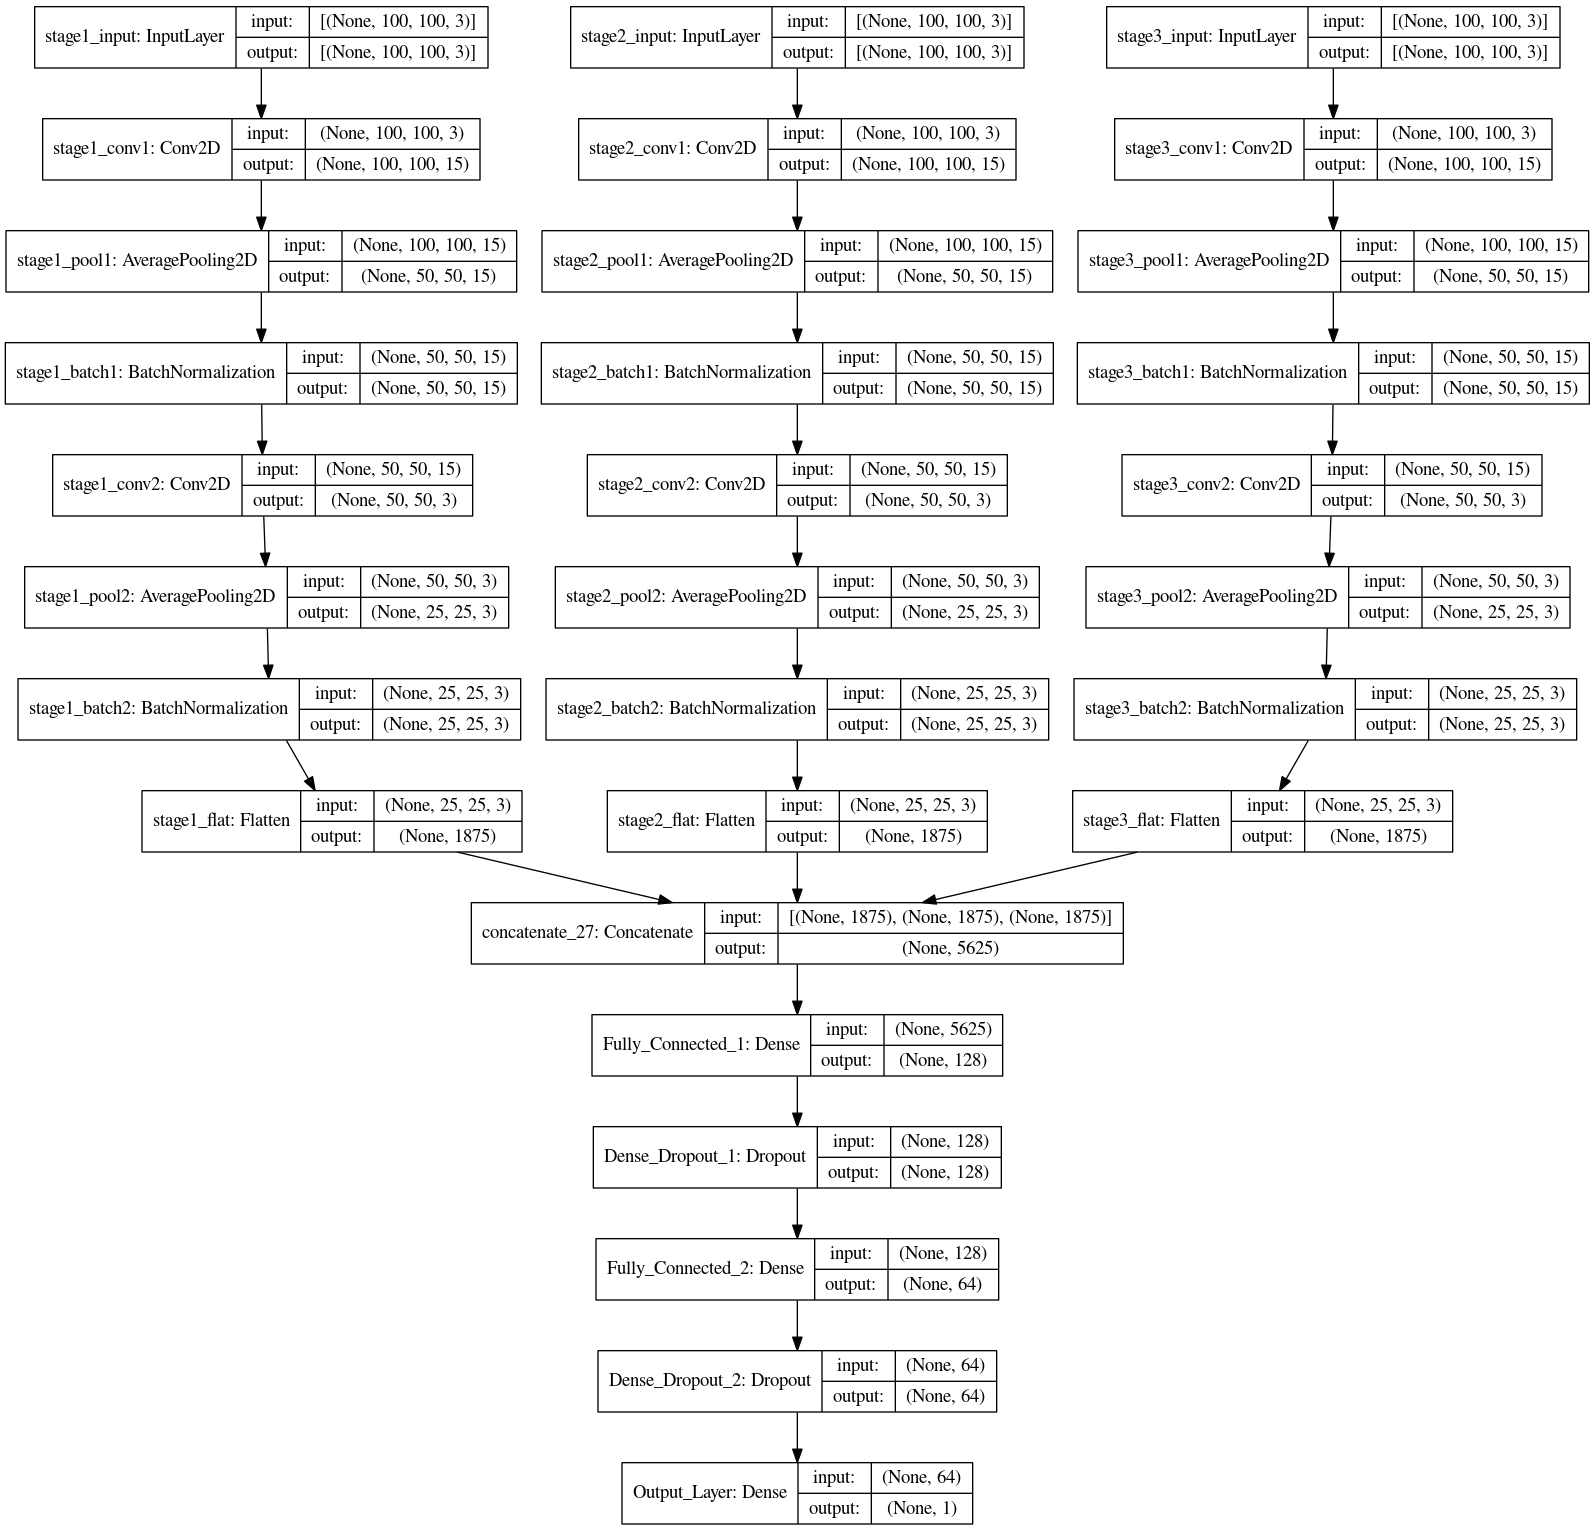

In [662]:
tf.keras.utils.plot_model(model, to_file='dense_plot.png', show_shapes=True, show_layer_names=True)

Epoch 1/20
14/14 [==============================] - 4s 229ms/step - loss: 6433.2388 - root_mean_squared_error: 80.2075 - val_loss: 4190.8701 - val_root_mean_squared_error: 64.7369
Epoch 2/20
14/14 [==============================] - 3s 221ms/step - loss: 1478.6768 - root_mean_squared_error: 38.4536 - val_loss: 4793.4717 - val_root_mean_squared_error: 69.2349
Epoch 3/20
14/14 [==============================] - 3s 214ms/step - loss: 2044.6626 - root_mean_squared_error: 45.2179 - val_loss: 2896.3293 - val_root_mean_squared_error: 53.8176
Epoch 4/20
14/14 [==============================] - 3s 212ms/step - loss: 2236.9927 - root_mean_squared_error: 47.2969 - val_loss: 1770.0682 - val_root_mean_squared_error: 42.0722
Epoch 5/20
14/14 [==============================] - 3s 213ms/step - loss: 2148.2493 - root_mean_squared_error: 46.3492 - val_loss: 2849.6816 - val_root_mean_squared_error: 53.3824
Epoch 6/20
14/14 [==============================] - 3s 214ms/step - loss: 1508.6150 - root_mean_squa

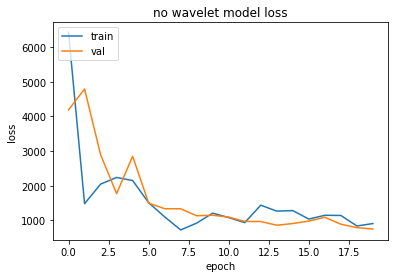

In [719]:
model.compile(
    loss = keras.losses.MeanSquaredError(), 
    optimizer = "adam",
    metrics = tf.keras.metrics.RootMeanSquaredError()
)

history = model.fit([stage_1_train, stage_2_train, stage_3_train], y_train, 
          batch_size = 5, 
          epochs = 20, 
          validation_data = ([stage_1_test, stage_2_test, stage_3_test], y_test), 
          )

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('no wavelet model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], 
           loc='upper left')
plt.show()

[120. 115. 100.  85.  75.  70.  65.  65.  75.  85.  65. 120. 100.  75.
 115.  75.  70.]
[ 67.786644  74.25966   60.686874  50.077515  74.81994   46.165913
  83.79177   98.96508   59.551617  77.74659   57.927177 112.732864
 102.28985  126.21747  101.28898   80.61121   85.81063 ]


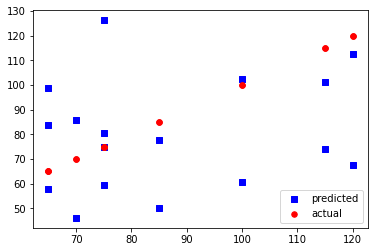

In [722]:
y_pred = model.predict([stage_1_test, stage_2_test, stage_3_test])
y_pred = y_pred.reshape(y_pred.shape[0])

print(y_test)
print(y_pred)

fig = plt.figure()
ax1 = fig.add_subplot(111)

ax1.scatter(y_test, y_pred, s=30, c='b', marker="s", label='predicted')
ax1.scatter(y_test, y_test, s=30, c='r', marker="o", label='actual')
plt.legend(loc='lower right')
plt.show()

on average, the model's prediction is 30.040382892441222 % off of the true max wind speed.
the standard deviation of the error is 24.472109146782824 knots/hr.


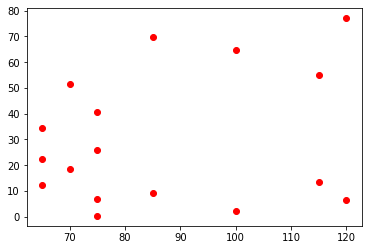

In [723]:
import math

percent_error = 0
err_vals = []


for i in range(len(y_test)):
    err = ((y_pred[i] - y_test[i])/y_pred[i])*100
    err_vals = np.append(err_vals, abs(err))
    percent_error = percent_error + abs(err)

mean_error = percent_error/len(y_test)

std_dev_err = err_vals - mean_error
std_dev_err = np.power(std_dev_err, 2)
std_dev_sum = np.sum(std_dev_err)

std_dev = math.sqrt(std_dev_sum/len(err_vals))

print("on average, the model's prediction is", mean_error, "% off of the true max wind speed.")
print("the standard deviation of the error is", std_dev, "knots/hr.")

plt.plot(y_test, err_vals, "ro")

[ 75. 105.  90.  80. 120. 120.  80.  65. 105.  70.  75. 105. 120. 100.
 125.  85.  75.  75. 145.  80.  85.  90.  75.  80.  65.  70. 105. 125.
  70.  90.  80.  65. 115. 125. 105. 120.  65.  70.  75. 125. 125.  85.
 115. 120.  70. 160. 155.  75. 145.  85.  70. 125. 100.  70.  70.  65.
  95. 105. 110.  65.  75. 120.  70.  80. 135. 115. 100. 100. 110.  90.
  95.]
[ 63.621883  74.25207   85.73393   67.40442   89.555214 133.52554
  77.52279   57.772488  88.896835  55.474697  61.46399   94.492516
  64.638176  72.78622   83.14689   79.557846  53.02427   78.50034
 133.23456   74.57247   56.357784  75.53317   64.59409   72.370705
  59.409122  71.239075 102.14491  125.75788   55.15289   84.044846
  84.96973   64.877975  99.17434   94.47669   86.30307  104.41352
  61.956924  57.26902   61.740635  98.68275  114.87965   65.77408
  84.40147   96.13337   64.0435   144.77728  129.57506   72.338295
 150.69771   67.365524  57.09145  122.13685  100.74853   58.839634
  63.547832  59.52152   78.18735   74.0

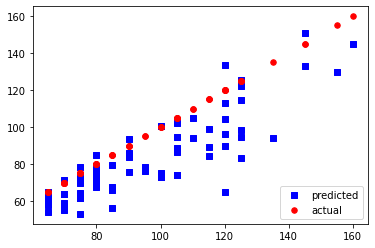

In [670]:
train_pred = model.predict([stage_1_train, stage_2_train, stage_3_train])
train_pred = train_pred.reshape(train_pred.shape[0])

print(y_train)
print(train_pred)

fig = plt.figure()
ax1 = fig.add_subplot(111)

ax1.scatter(y_train, train_pred, s=30, c='b', marker="s", label='predicted')
ax1.scatter(y_train, y_train, s=30, c='r', marker="o", label='actual')
plt.legend(loc='lower right')
plt.show()

In [653]:
index_test

array([64, 23, 84, 15,  8,  0, 54, 29, 20, 25, 62, 81, 50, 57, 37, 80, 78,
       40])

In [50]:
from sklearn.metrics import precision_score, recall_score, f1_score

print("precision: ", precision_score(y_test_spatial, y_pred_round))
print("recall: ", recall_score(y_test_spatial, y_pred_round))
print("f1 score: ", f1_score(y_test_spatial, y_pred_round))

NameError: name 'y_test_spatial' is not defined

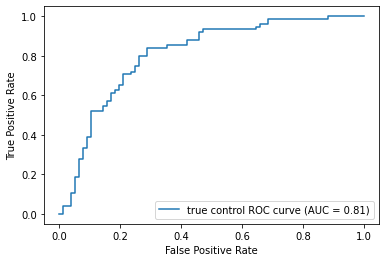

In [33]:
fpr, tpr, thresholds = metrics.roc_curve(y_test_spatial, y_pred)
roc_auc = metrics.auc(fpr, tpr)
display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,
                                   estimator_name='true control ROC curve')
display.plot()

plt.show()

In [34]:
def draw_confusion_matrix(y, yhat, classes):
    plt.cla()
    plt.clf()
    matrix = confusion_matrix(y, yhat)
    plt.imshow(matrix, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title("true control confusion matrix")
    plt.colorbar()
    num_classes = len(classes)
    plt.xticks(np.arange(num_classes), classes, rotation=90)
    plt.yticks(np.arange(num_classes), classes)

    fmt = 'd'
    thresh = matrix.max() / 2.
    for i, j in itertools.product(range(matrix.shape[0]), range(matrix.shape[1])):
        plt.text(j, i, format(matrix[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if matrix[i, j] > thresh else "black")

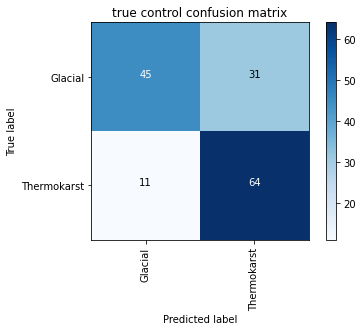

In [35]:
draw_confusion_matrix(y_test_spatial, y_pred_round, ['Glacial', 'Thermokarst'])
fig = plt.ylabel('True label')
fig = plt.xlabel('Predicted label')
fig = plt.show()

In [19]:
import json

name = '/home/fun/data/AL202003' + '/profile.json'
f = open(name)
profile = json.load(f)
paths = profile['path']

valid_dates = []
for path in paths:
    valid_dates = np.append(valid_dates, str(path['date']))
    
imergs = glob.glob('/home/fun/data/AL182012/imerg_precipitation_*.npy', recursive = True)
imergs.sort()
imergs = imergs[0:3]
print(len(imergs))

valid = True

days = []

for imerg in imergs:
    days = np.append(days, imerg[-17:-9])
    
for day in days:
    if day not in valid_dates:
        valid = False
        
print(valid, valid_dates, days)

3
False ['20031204' '20031204' '20031205' '20031205' '20031205' '20031205'
 '20031206' '20031206' '20031206' '20031206'] ['20121021' '20121022' '20121022']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


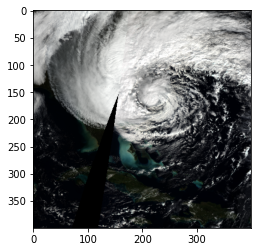

In [781]:
testname = '/home/fun/data/AL182012/10_modis_satellite_20121027.npy'
test = np.load(testname)

plt.imshow(test)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


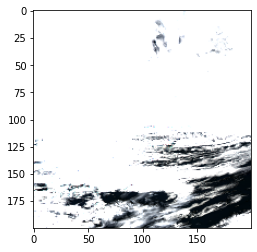

In [770]:
testname = '/home/fun/data/AL142005/modis_satellite_20050912.npy'
test = np.load(testname)

plt.imshow(test)